In [1]:
import os, sys
import math
from copy import deepcopy
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats

import torch as th
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.environ['DGLBACKEND'] = 'pytorch'
import dgl
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from torch.utils.data import Subset
from torch.utils.data.sampler import SubsetRandomSampler

import dgl.function as fn

In [3]:
device = 'cuda' if th.cuda.is_available() else 'cpu'
device = th.device(device)
device

device(type='cpu')

In [4]:
from generate_dataset.generated_graph_dataset import GeneratedGraphDataset

In [6]:
dataset = GeneratedGraphDataset(raw_dir='generate_dataset/LTR_TIR_with_real')
len(dataset)

40000

In [7]:
# create train/val/test split dataloaders
split_idx = dataset.split_idx

train_sampler = SubsetRandomSampler(split_idx['train'])
val_subset = Subset(dataset, split_idx['valid'])
test_subset = Subset(dataset, split_idx['test'])


In [8]:
bs = 32
train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=bs, drop_last=False)
val_dataloader = GraphDataLoader(
    val_subset, shuffle=False, batch_size=bs, drop_last=False)
test_dataloader = GraphDataLoader(
    test_subset, shuffle=False, batch_size=bs, drop_last=False)

In [9]:
len(val_subset), len(test_subset)

(4000, 4000)

In [10]:
it = iter(train_dataloader)
batch = next(it)

In [11]:
batch

[Graph(num_nodes=14488, num_edges=26136,
       ndata_schemes={'feat': Scheme(shape=(5,), dtype=torch.float32)}
       edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}),
 tensor([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
         1, 1, 1, 1, 1, 1, 0, 1])]

In [12]:
dgl.unbatch(batch[0])

[Graph(num_nodes=466, num_edges=701,
       ndata_schemes={'feat': Scheme(shape=(5,), dtype=torch.float32)}
       edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}),
 Graph(num_nodes=524, num_edges=800,
       ndata_schemes={'feat': Scheme(shape=(5,), dtype=torch.float32)}
       edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}),
 Graph(num_nodes=219, num_edges=347,
       ndata_schemes={'feat': Scheme(shape=(5,), dtype=torch.float32)}
       edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}),
 Graph(num_nodes=435, num_edges=822,
       ndata_schemes={'feat': Scheme(shape=(5,), dtype=torch.float32)}
       edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}),
 Graph(num_nodes=488, num_edges=1034,
       ndata_schemes={'feat': Scheme(shape=(5,), dtype=torch.float32)}
       edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}),
 Graph(num_nodes=261, num_edges=407,
       ndata_schemes={'feat': Scheme(shape=(5,), dtype=to

In [12]:
# ndata - node data
# batch[0].ndata['feat']
# edata - edge data
# batch[0].edata['feat']

In [13]:
emb_dim = 5

In [14]:
# copy_{u} - source node
# copy_{v} - destination, neighbour node

class GINLayer(nn.Module):
    def __init__(self, emb_dim):
        super(GINLayer, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 2*emb_dim), 
            nn.BatchNorm1d(2*emb_dim), 
            nn.ReLU(), 
            nn.Linear(2*emb_dim, emb_dim) #from above
        )
        self.eps = nn.Parameter(th.FloatTensor([0]))
        

    def reset_parameters(self): # reset the parameters of the MLP
        # MLP
        for layer in self.mlp:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        # EPS
        nn.init.constant_(self.eps, 0.)
        
    def extra_repr(self):
        # Add "eps" to the string representation
        return f'(eps): nn.Parameter'
        
    def forward(self, g, x_node, x_edge):
        """
        g : The graph used for message passing
        x_node : AtomEncodings
        x_edge : BondEncodings
        """
        
        with g.local_scope():
            # Store edge features to 'bond' key in g.edata
            g.edata['bond'] = x_edge
            # Store node features to 'x' key in g.ndata
            g.srcdata['x'] = x_node
            
            # calculate the right part h_i = sum_j( F.relu (h_j + e_ij) )
                
            ## 1. take the sum
            g.apply_edges( # see https://docs.dgl.ai/api/python/dgl.function.html#dgl-built-in-function
                fn.u_add_e('x', 'bond', 'm')
            )
            ##2. apply ReLU
            g.edata['m'] = F.relu(g.edata['m'])
            
            ## 3. sum the modified messages https://docs.dgl.ai/en/1.0.x/generated/dgl.DGLGraph.update_all.html
            g.update_all(
                fn.copy_e('m', 'm'), # creating messages
                fn.sum('m', 'mp'), # sending messages to message passing
            )
            ## extract the final output into variable "h_mp"
            h_mp = g.dstdata['mp'] # will be used in the next layer
                    
        # GIN update equation
        out = self.mlp((1 + self.eps) * x_node + h_mp)

        return out

In [15]:
gin = GINLayer(emb_dim)

In [16]:
sum(p.numel() for p in gin.parameters())

136

In [17]:
## Node convolution
class NodeGNN(nn.Module):
    def __init__(self, emb_dim, num_layers, dropout):
        super(NodeGNN, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        
        # self.atom_encoder = AtomEncoder(emb_dim)
        # self.bond_encoder = BondEncoder(emb_dim)
        
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(GINLayer(emb_dim))
            self.batch_norms.append(nn.BatchNorm1d(emb_dim))
    
    def reset_parameters(self):

        # for emb in self.atom_encoder.atom_embedding_list: # Atom embeddings
        #     nn.init.xavier_uniform_(emb.weight.data)
        # 
        # for emb in self.bond_encoder.bond_embedding_list: # Bond embeddings
        #     nn.init.xavier_uniform_(emb.weight.data)

        # reset parameters for the GIN and batch norm layers
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.batch_norms:
            bn.reset_parameters()
    
    def forward(self, g):
        """        
        (node_embeddings, edge_embeddings) -> GIN -> Batch Norm -> ReLU -> Dropout
        """
        
        h = g.ndata['feat']
        edge_embedding = g.edata['feat']
        
        
        for layer in range(self.num_layers):
            h = self.convs[layer](g, h, edge_embedding)
            h = self.batch_norms[layer](h)
            if layer == self.num_layers - 1:
                #remove relu for the last layer
                h = F.dropout(h, self.dropout, training=self.training)
            else:
                h = F.dropout(F.relu(h), self.dropout, training=self.training)
        return h

In [18]:
# test model
node_gnn = NodeGNN(emb_dim, 1, 0.5)
# node_gnn

In [19]:
#418501
sum(p.numel() for p in node_gnn.parameters())

146

In [20]:
class GraphGNN(nn.Module):
    def __init__(self, emb_dim, num_layers, num_classes, node_cls, dropout):
        super(GraphGNN, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.node_GNN = node_cls(emb_dim, num_layers, dropout) # node-level GNN, returns node embeddings for every single graph
        #node representation -> graph representation
        self.graph_pred_linear = nn.Linear(emb_dim, num_classes)
        self.reset_parameters()

    def reset_parameters(self):
        self.node_GNN.reset_parameters()
        self.graph_pred_linear.reset_parameters()


    def forward(self, g): # !!! g is a batched super-graph
        h_node = self.node_GNN(g) # node-level embeddings with self.node_GNN
        
        # pool the node-level embedding to get graph representations
        with g.local_scope():
            g.ndata['h'] = h_node # store node data in h
            h_graph = dgl.mean_nodes(g, 'h') # average the nodes in the component graphs 32 graph layer embs
        
        # generate a final prediction by sending the graph-level representation
        # through self.graph_pred_linear
        pred = self.graph_pred_linear(h_graph)
        return pred

In [21]:
num_layers = 5
num_classes = 2
dropout = 0.5

model = GraphGNN(emb_dim, num_layers, num_classes, NodeGNN, dropout)

In [22]:
sum(p.numel() for p in model.parameters())

742

In [23]:
# assert False

In [23]:
N_runs = 1
train_args = dict(epochs=15, lr=0.001, eval_steps=1, log_steps=1)

In [24]:
from utils.edited_utils import repeat_experiments
logger = repeat_experiments(
    model, train_dataloader, val_dataloader, test_dataloader, 
    device, train_args, N_runs)

Run: 01, Epoch: 01, Loss: 0.1263, Train: 0.6194 Accuracy, Valid: 0.6288 Accuracy, Test: 0.6178 Accuracy
---
Run: 01, Epoch: 02, Loss: 0.0157, Train: 0.9973 Accuracy, Valid: 0.9985 Accuracy, Test: 0.9985 Accuracy
---
Run: 01, Epoch: 03, Loss: 0.0088, Train: 0.7926 Accuracy, Valid: 0.7977 Accuracy, Test: 0.7925 Accuracy
---
Run: 01, Epoch: 04, Loss: 0.0070, Train: 0.9676 Accuracy, Valid: 0.9665 Accuracy, Test: 0.9688 Accuracy
---
Run: 01, Epoch: 05, Loss: 0.0073, Train: 0.9845 Accuracy, Valid: 0.9865 Accuracy, Test: 0.9842 Accuracy
---
Run: 01, Epoch: 06, Loss: 0.0054, Train: 0.5001 Accuracy, Valid: 0.5028 Accuracy, Test: 0.4963 Accuracy
---
Run: 01, Epoch: 07, Loss: 0.0052, Train: 0.9980 Accuracy, Valid: 0.9990 Accuracy, Test: 0.9985 Accuracy
---
Run: 01, Epoch: 08, Loss: 0.0054, Train: 0.5001 Accuracy, Valid: 0.5028 Accuracy, Test: 0.4963 Accuracy
---
Run: 01, Epoch: 09, Loss: 0.0052, Train: 0.9975 Accuracy, Valid: 0.9985 Accuracy, Test: 0.9978 Accuracy
---
Run: 01, Epoch: 10, Loss: 0.

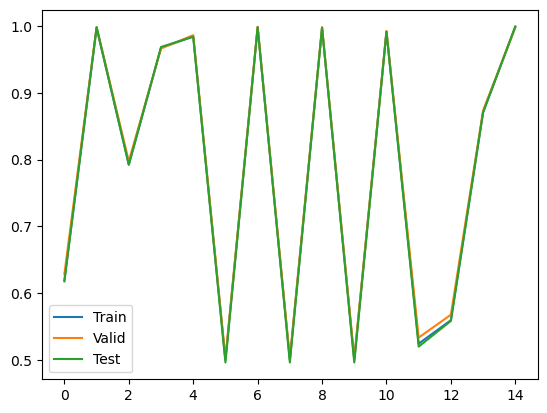

In [25]:
logger.plot_results()

In [27]:
import pickle
with open('model_LTR_TIR_with_real_15e_2.pkl', 'wb') as f:
    pickle.dump(model, f)

In [28]:
import pickle
with open('model_LTR_NO_with_real_15e_2.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [29]:
loaded_model

GraphGNN(
  (node_GNN): NodeGNN(
    (convs): ModuleList(
      (0-4): 5 x GINLayer(
        (eps): nn.Parameter
        (mlp): Sequential(
          (0): Linear(in_features=5, out_features=10, bias=True)
          (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Linear(in_features=10, out_features=5, bias=True)
        )
      )
    )
    (batch_norms): ModuleList(
      (0-4): 5 x BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_linear): Linear(in_features=5, out_features=2, bias=True)
)

In [41]:
from sklearn.metrics import accuracy_score
def test_with_examples(model, loader, device):
    model = model.to(device)
    model.eval()

    y_true = []
    y_pred = []
    incorrect_graphs = []
    incorrect_labels = []
    incorrect_index = []

    for i, (batched_graph, labels) in enumerate(loader):
        batched_graph = batched_graph.to(device)
        pred = model(batched_graph)
        y_true.append(labels.view(-1).detach())
        y_pred.append(pred.detach().argmax(axis=1))
        
        if  labels.view(-1).detach() == 1:
            print(labels.view(-1).detach())
            
        if y_true[-1] != y_pred[-1]:
            incorrect_graphs.append(batched_graph)
            incorrect_labels.append(y_true[-1])
            incorrect_index.append(i)

    y_true = th.cat(y_true, dim=0).numpy()
    y_pred = th.cat(y_pred, dim=0).numpy()

    accuracy = accuracy_score(y_true, y_pred)

    return accuracy, incorrect_graphs, incorrect_labels, incorrect_index

In [31]:
import dgl
import torch
import matplotlib.pyplot as plt

def visualize_edge_weight_adjacency(g, edge_feat_key='feat'):
    num_nodes = g.num_nodes()
    src, dst = g.edges() 

    edge_weights = g.edata[edge_feat_key]
    if edge_weights.dim() > 1:
        edge_weights = edge_weights.squeeze()

    adj_matrix = torch.zeros((num_nodes, num_nodes))
    adj_matrix[src, dst] = edge_weights

    rows, cols = np.nonzero(adj_matrix.numpy())

    plt.scatter(cols, rows, c='black', s=0.5)
    plt.gca().set_aspect('equal')
    plt.grid(True)
    plt.show()
    return adj_matrix


In [34]:
test_dataset = GeneratedGraphDataset(raw_dir='generate_dataset/test_LTR_LINE')
print(len(test_dataset))
test_dataloader = GraphDataLoader(test_dataset, batch_size=1, shuffle=False)

936


In [35]:
import pickle
from utils.edited_utils import test
with open('model_LTR_INNER_with_real_15e_2.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
test_accuracy = test(model, test_dataloader, device)
test_accuracy

0.15918803418803418

In [42]:
accuracy, incorrect_graphs, incorrect_labels, incorrect_index = test_with_examples(model, test_dataset, device)
accuracy

tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tens

0.15918803418803418

In [ ]:
incorrect_labels

In [46]:
from collections import Counter
import torch

label_counter = Counter()
total_samples = 0

for batch in test_dataloader:
    labels = batch[1]
    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()
    
    label_counter.update(labels)
    total_samples += len(labels)

# считаем доли
label_distribution = {label: count / total_samples for label, count in label_counter.items()}

print("Label counts:", label_counter)
print("Label distribution:", label_distribution)

Label counts: Counter({0: 829, 1: 107})
Label distribution: {0: 0.8856837606837606, 1: 0.11431623931623931}


In [40]:
for i in range(len(incorrect_graphs)):
    if incorrect_labels[i] == 1:
        print(incorrect_index[i])
        visualize_edge_weight_adjacency(incorrect_graphs[i])